In [1]:
# show the difference in the distributions p(t_r=T)p(tl<T) and p(t_l=T)p(tr<T)p(ir(T)<z)
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.stats.norm import logcdf 
from jax.scipy.stats.norm import cdf 
import os
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib as mpl
import numpy_indexed as npi
from itertools import groupby
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from compute_trial_data import compute_trial_data
from mouse_fitting_functions import loadMouseWeights
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker



def inv_gauss_pdf(thr, drift, v, t):
    
    A = np.log(thr / np.sqrt(2 * np.pi * v * t ** 3)) - (thr - drift * t) ** 2 / (2 * v * t)
    
    return np.exp(A) 

def inv_gauss_cdf(thr, drift, v, t):

    # A and logB are separated for numerical stability
    A = cdf((drift * t - thr) / np.sqrt(v * t))
    logB = 2. * thr * (drift / v) + logcdf(-(drift * t + thr) / np.sqrt(v * t))
    
    return A + np.exp(logB)

def integrator_dist(thr, drift, v, t):
    
    logB = 2. * thr * (drift / v) + logcdf(-(drift * t + thr) / np.sqrt(v * t))
    
    return np.exp(logB)


def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)


def countColEls(A):

    lens = [len(el) for el in A]

    sorted_lens = sorted(lens, reverse=True)

    diff_sorted_lens = -np.diff(sorted_lens)

    runs_sorted_lens = [sum(1 for i in g) for k,g in groupby(sorted_lens)]

    runs_cum_sum = np.cumsum(runs_sorted_lens)

    num_els_in_col = []

    counter = 0
    for i in range(len(runs_cum_sum)-1):

        while diff_sorted_lens[counter] == 0:

            counter+=1

        num_els_in_col += [runs_cum_sum[i]] * diff_sorted_lens[counter]

        counter+=1

    num_els_in_col+=[len(A)]*(max(lens)-len(num_els_in_col))
    
    return np.array(num_els_in_col[::-1])

In [2]:
def session_mean_RR(all_mice):

    n_mice = len(all_mice)

    mice_session_RR = np.empty(n_mice, dtype=object)
    mice_session_er = np.empty(n_mice, dtype=object)
    mice_session_rt = np.empty(n_mice, dtype=object)

    for mouse_index in range(n_mice):

        mouse_fit = loadMouseWeights(all_mice[mouse_index], iteration=0)

        # Some useful values to have around
        K, N = mouse_fit['w'].shape

        # find corr for all trials of real mouse
        corr_tot = (mouse_fit['data']['r'] == (mouse_fit['data']['inputs']['c'] > 0)) * 1

        for j in range(len(corr_tot)):
            if mouse_fit['data']['inputs']['c'][j] == 0:
                corr_tot[j] = (np.random.rand(1) > .5) * 1

        # session info
        max_sessions = len(mouse_fit['data']['dayLength'])
        session_boundaries = np.cumsum(mouse_fit['data']['dayLength'], dtype=int)
        session_boundaries_plt = np.insert(session_boundaries, 0, 0)


        session_av_acc = np.empty(max_sessions, dtype=object)
        ci_session_av_acc = np.empty((2, max_sessions))
        session_av_rt = np.empty(max_sessions, dtype=object)
        sem_av_rt = np.empty(max_sessions)


        for k in range(max_sessions):

            # selecting input data corresponding to session of interest for real mouse
            session_beg = session_boundaries_plt[k]
            session_end = session_boundaries_plt[k + 1]

            # ----------
            # REAL MOUSE
            # ----------

            cs = mouse_fit['data']['inputs']['c'][session_beg:session_end]
            rt = np.array(mouse_fit['data']['T'][session_beg:session_end], dtype=float)  # todo: do these have to be floats?
            resp = np.array(mouse_fit['data']['r'][session_beg:session_end], dtype=float)
            corr = np.array(corr_tot[session_beg:session_end], dtype=float)


            # find average accuracy in this session
            session_av_acc[k] = np.mean(corr)

            # find median rt in this session
            session_av_rt[k] = np.mean(rt)


        session_RR = np.divide(session_av_acc, session_av_rt + (1-session_av_acc)*2 + 3.4632)

        mice_session_RR[mouse_index] = session_RR
        mice_session_er[mouse_index] = 1-session_av_acc
        mice_session_rt[mouse_index] = session_av_rt

    return mice_session_RR, mice_session_er, mice_session_rt

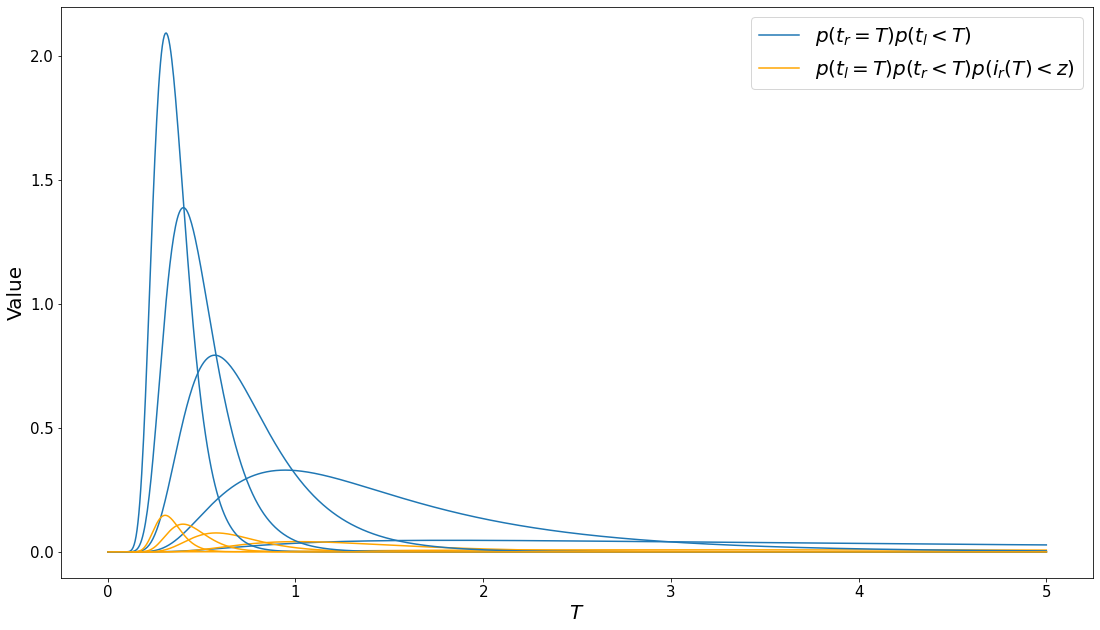

In [3]:
T = np.linspace(0.001, 5, 1000)

for drift in np.linspace(0.1, 5, 5):

    dist1 = inv_gauss_pdf(1.5, drift, 1, T)*inv_gauss_cdf(1.5, drift, 1, T)
    dist2 = inv_gauss_pdf(1.5, drift, 1, T)*inv_gauss_cdf(1.5, drift, 1, T)*integrator_dist(1.5, drift, 1, T)

    l1, = plt.plot(T, dist1, c='C0')
    l2, = plt.plot(T, dist2, c='orange')


legend1 = plt.legend([l1, l2], ['$p(t_r=T)p(t_l<T)$', '$p(t_l=T)p(t_r<T)p(i_r(T)<z)$'], loc='upper right', prop={'size': 20})
plt.xlabel('$T$', fontsize=20)
plt.ylabel('Value', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('dist_comparison.png', dpi=400)

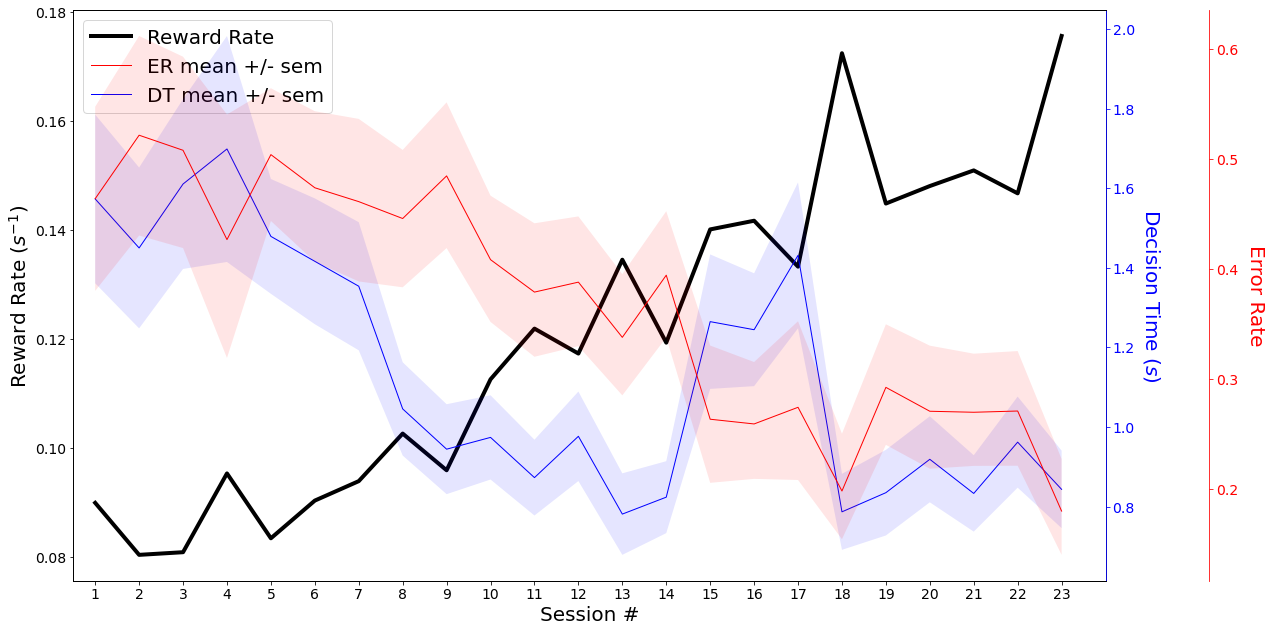

In [4]:
# reward rate for a mouse

mouse_fit = loadMouseWeights('DAP011', iteration=0)

# Some useful values to have around
K, N = mouse_fit['w'].shape

# find corr for all trials of real mouse
corr_tot = (mouse_fit['data']['r'] == (mouse_fit['data']['inputs']['c'] > 0)) * 1

for j in range(len(corr_tot)):
    if mouse_fit['data']['inputs']['c'][j] == 0:
        corr_tot[j] = (np.random.rand(1) > .5) * 1

# session info
max_sessions = len(mouse_fit['data']['dayLength'])
session_boundaries = np.cumsum(mouse_fit['data']['dayLength'], dtype=int)
session_boundaries_plt = np.insert(session_boundaries, 0, 0)

session_av_acc = np.empty(max_sessions, dtype=float)
ci_session_av_acc = np.empty((2, max_sessions), dtype=float)
session_av_rt = np.empty(max_sessions, dtype=float)
sem_av_rt = np.empty(max_sessions, dtype=float)


for k in range(max_sessions):

        # selecting input data corresponding to session of interest for real mouse
        session_beg = session_boundaries_plt[k]
        session_end = session_boundaries_plt[k + 1]

        # ----------
        # REAL MOUSE
        # ----------

        cs = mouse_fit['data']['inputs']['c'][session_beg:session_end]
        rt = np.array(mouse_fit['data']['T'][session_beg:session_end], dtype=float)  # todo: do these have to be floats?
        resp = np.array(mouse_fit['data']['r'][session_beg:session_end], dtype=float)
        corr = np.array(corr_tot[session_beg:session_end], dtype=float)


        # find average accuracy in this session
        session_av_acc[k] = np.mean(corr)

        # find confidence interval for this mean
        temp = proportion_confint(np.sum(corr), len(corr), method='binom_test', alpha=0.05)
        lower = session_av_acc[k] - temp[0]
        upper = temp[1] - session_av_acc[k]
        ci_session_av_acc[0][k] = lower
        ci_session_av_acc[1][k] = upper
        
        # find median rt in this session
        session_av_rt[k] = np.mean(rt)

        # find confidence interval for this median
        sem_av_rt[k] = np.std(rt, axis=0) / np.sqrt(session_end - session_beg)
        
        
session_RR = np.divide(session_av_acc, session_av_rt + (1-session_av_acc)*2 + 3.4632)
        
fig1 = plt.figure()
axs1 = fig1.add_subplot(1, 1, 1)

axsecond = axs1.twinx()

axthird = axs1.twinx()

axs1.set_xlim(left=0.5, right=max_sessions+1)
axs1.set_xlabel('Session #', size=20)
axs1.set_xticks(np.arange(1, max_sessions+1))
#axs1.set_title('Reward Rate vs. Sessions', size=20)


l1 =axs1.plot(np.arange(1, max_sessions+1), session_RR, lw=4, c='k', label='Reward Rate')

l2 = axthird.plot(np.arange(1, max_sessions+1), 1-session_av_acc, label='ER mean +/- sem', c='r', lw=1)
axthird.fill_between(np.arange(1, max_sessions+1), 1-session_av_acc-ci_session_av_acc[1], 1-session_av_acc+ci_session_av_acc[0], facecolor='r', alpha=0.1)

l3 = axsecond.plot(np.arange(1, max_sessions+1), session_av_rt, label='DT mean +/- sem', c='b', lw=1)
axsecond.fill_between(np.arange(1, max_sessions+1), session_av_rt-1.96*sem_av_rt, session_av_rt+1.96*sem_av_rt, facecolor='b', alpha=0.1)


axs1.set_ylabel('Reward Rate ($s^{-1}$)', color='k', size=20)
axsecond.set_ylabel('Decision Time ($s$)', color='b', size=20, rotation=-90, labelpad=27)
axthird.set_ylabel('Error Rate', color='r', size=20, rotation=-90, labelpad=27)


lns = l1+l2+l3
labs = [l.get_label() for l in lns]
axs1.legend(lns, labs, loc=0, prop={'size': 20})

# axs1.legend(prop={'size': 20})
# legend1 = axsecond.legend([l1], ['DT mean +/- sem'], loc='upper right', prop={'size': 20})
#axsecond.legend()

axs1.tick_params(axis='both', which='major', labelsize=14)
axsecond.tick_params(axis='both', which='major', labelsize=14)
axthird.tick_params(axis='both', which='major', labelsize=14)
axsecond.spines['right'].set_color('b')
axthird.spines['right'].set_color('r')
axsecond.tick_params(axis='y', colors='b')
axthird.tick_params(axis='y', colors='r')

axthird.spines["right"].set_position(("axes", 1.1))

 
fig1.set_size_inches(18.5, 10.5)
    
fig1.savefig('reward_rate_example_mouse.png', dpi=400)

In [ ]:
# now for all mice - original sessions

fig2 = plt.figure()
axs2 = fig2.add_subplot(1, 1, 1)


all_mice = ['DAP007', 'DAP009', 'DAP011', 'DAP013', 'DAP014', 'DAP015', 'DAP017', 
           'DAP019', 'DAP022', 'DAP023', 'DAP024', 'DAP027', 'DAP028', 'DAP031', 'DAP033', 'DAP035', 'DAP037']



# plot the mean RR's

mice_session_RR, _, _ = session_mean_RR(all_mice)

for index in range(len(mice_session_RR)):

    axs2.plot(np.arange(1, len(mice_session_RR[index])+1), mice_session_RR[index])


mice_mean_RR, std_mice_mean_RR = tolerant_mean(mice_session_RR)


num_traces = countColEls(mice_session_RR)

sem_mice_mean_RR = std_mice_mean_RR/np.sqrt(num_traces)

axs2.plot(np.arange(len(mice_mean_RR))+1, mice_mean_RR, label='mean +/- sem', c='k', lw=4)
axs2.fill_between(np.arange(len(mice_mean_RR))+1, mice_mean_RR-1.96*sem_mice_mean_RR, mice_mean_RR+1.96*sem_mice_mean_RR, facecolor='k', alpha=0.1)

axs2.set_xlim(left=0.5, right=len(mice_mean_RR)+1)
axs2.set_xlabel('Session #', size=20)
axs2.set_xticks(np.arange(1, len(mice_mean_RR)+1, 2))
axs2.set_ylabel('Reward Rate ($s^{-1}$)', size=20)
#axs2.set_title('Reward Rate vs. Sessions', size=20)

axs2.tick_params(axis='both', which='major', labelsize=14)

#axs10.errorbar(np.arange(1, max_sessions+1), session_RR, yerr=ci_session_av_acc, color='k', markersize=6,
#              capsize=5, label='original')
axs2.legend(prop={'size': 20})


fig2.set_size_inches(18.5, 10.5)

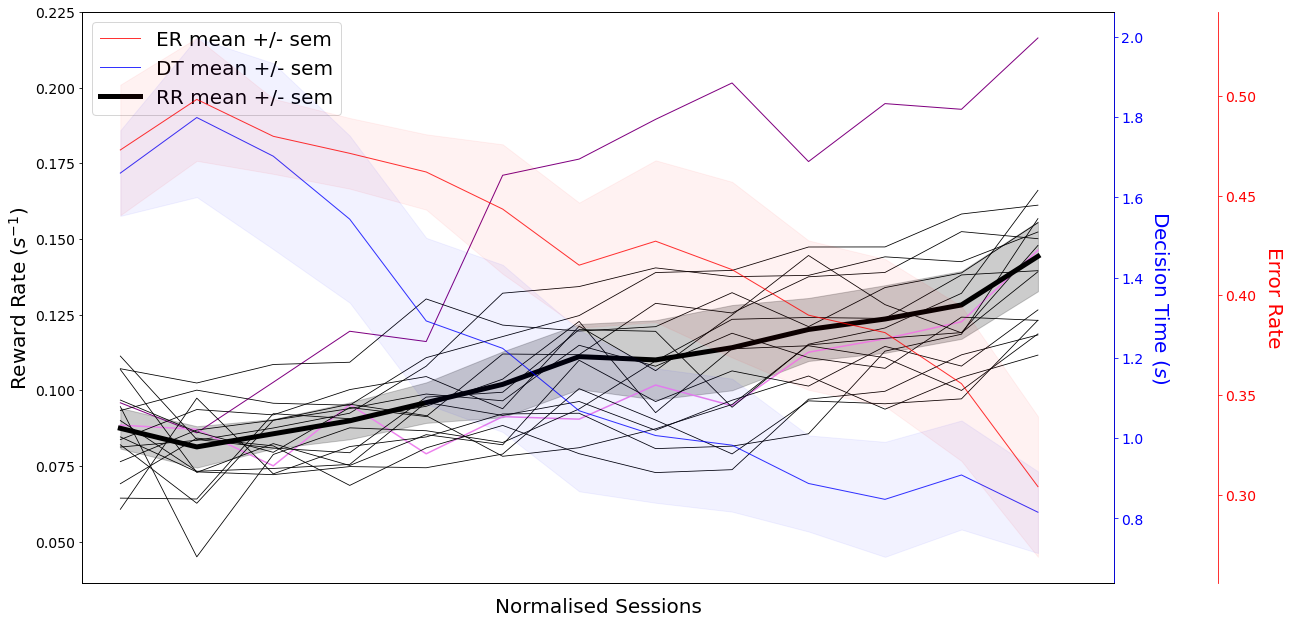

In [10]:
# now for all mice - normalised sessions

# create figure and axes
fig3 = plt.figure()
axs3 = fig3.add_subplot(1, 1, 1)

axs3second = axs3.twinx()
axs3third = axs3.twinx()


all_mice = ['DAP007', 'DAP009', 'DAP011', 'DAP013', 'DAP014', 'DAP015', 'DAP017', 
           'DAP019', 'DAP022', 'DAP023', 'DAP024', 'DAP027', 'DAP028', 'DAP031', 'DAP033', 'DAP035', 'DAP037']

mice_session_RR, mice_session_er, mice_session_dt = session_mean_RR(all_mice)

n_mice = len(all_mice)

max_session_array = np.array([len(el) for el in mice_session_RR])

# find the smallest number of trials that a mouse has, this will be no. of windows
n_sessions_min = int(np.min(max_session_array))


mice_normalised_session_RR = np.empty((n_mice, n_sessions_min))
mice_normalised_session_er = np.empty((n_mice, n_sessions_min))
mice_normalised_session_dt = np.empty((n_mice, n_sessions_min))


for i in range(n_mice):
    

    if max_session_array[i] != n_sessions_min:

        window_length = int(np.floor(max_session_array[i]/n_sessions_min))
        remainder = int(max_session_array[i] % n_sessions_min)
#         print('n_trials', max_session_array[i])
#         print('window_length', window_length)
#         print('remainder', remainder)
        
        if remainder != 0:
        
            mice_normalised_session_RR[i, :] = np.mean(mice_session_RR[i][:-remainder].reshape(-1, window_length), 1)
            mice_normalised_session_RR[i, -1] = np.mean(mice_session_RR[i][-(remainder+window_length):])
            
            mice_normalised_session_er[i, :] = np.mean(mice_session_er[i][:-remainder].reshape(-1, window_length), 1)
            mice_normalised_session_er[i, -1] = np.mean(mice_session_er[i][-(remainder+window_length):])
            
            mice_normalised_session_dt[i, :] = np.mean(mice_session_dt[i][:-remainder].reshape(-1, window_length), 1)
            mice_normalised_session_dt[i, -1] = np.mean(mice_session_dt[i][-(remainder+window_length):])
            
        if remainder == 0:
            
            mice_normalised_session_RR[i, :] = np.mean(mice_session_RR[i].reshape(-1, window_length), 1)
            mice_normalised_session_er[i, :] = np.mean(mice_session_er[i].reshape(-1, window_length), 1)
            mice_normalised_session_dt[i, :] = np.mean(mice_session_dt[i].reshape(-1, window_length), 1)
            

    else:
        mice_normalised_session_RR[i, :] = mice_session_RR[i]
        mice_normalised_session_er[i, :] = mice_session_er[i]
        mice_normalised_session_dt[i, :] = mice_session_dt[i]

    if all_mice[i] == 'DAP009':

        axs3.plot(np.arange(1, n_sessions_min+1), mice_normalised_session_RR[i, :], lw=1, color='purple')
        
    elif all_mice[i] == 'DAP011':
        axs3.plot(np.arange(1, n_sessions_min+1), mice_normalised_session_RR[i, :], lw=1.5, color='violet')
    
    else:
        axs3.plot(np.arange(1, n_sessions_min+1), mice_normalised_session_RR[i, :], lw=0.8, color='k')

sem_RR_normalised_sessions = np.std(mice_normalised_session_RR, axis=0)/np.sqrt(n_mice)
sem_er_normalised_sessions = np.std(mice_normalised_session_er, axis=0)/np.sqrt(n_mice)
sem_dt_normalised_sessions = np.std(mice_normalised_session_dt, axis=0)/np.sqrt(n_mice)


l1 = axs3third.plot(np.arange(1, n_sessions_min+1), np.mean(mice_normalised_session_er, axis=0), color='r', lw=1, alpha=0.8, label='ER mean +/- sem')
# Plot 95% credible intervals on weights
axs3third.fill_between(np.arange(1, n_sessions_min+1),
                 np.mean(mice_normalised_session_er, axis=0) - 1.96 * sem_er_normalised_sessions,
                 np.mean(mice_normalised_session_er, axis=0) + 1.96 * sem_er_normalised_sessions, color='r', alpha=0.05)

l2 = axs3second.plot(np.arange(1, n_sessions_min+1), np.mean(mice_normalised_session_dt, axis=0), color='b', lw=1, alpha=0.8, label='DT mean +/- sem')
# Plot 95% credible intervals on weights
axs3second.fill_between(np.arange(1, n_sessions_min+1),
                 np.mean(mice_normalised_session_dt, axis=0) - 1.96 * sem_dt_normalised_sessions,
                 np.mean(mice_normalised_session_dt, axis=0) + 1.96 * sem_dt_normalised_sessions, color='b', alpha=0.05)


l3 = axs3.plot(np.arange(1, n_sessions_min+1), np.mean(mice_normalised_session_RR, axis=0), color='k', lw=5, label='RR mean +/- sem')
# Plot 95% credible intervals on weights
axs3.fill_between(np.arange(1, n_sessions_min+1),
                 np.mean(mice_normalised_session_RR, axis=0) - 1.96 * sem_RR_normalised_sessions,
                 np.mean(mice_normalised_session_RR, axis=0) + 1.96 * sem_RR_normalised_sessions, color='k', alpha=0.2)


axs3.set_xlim(left=0.5, right=n_sessions_min+1)
axs3.set_xlabel('Normalised Sessions', size=20, labelpad=15)
axs3.set_ylabel('Reward Rate ($s^{-1}$)', size=20)
#axs3.set_title('Reward Rate vs. Normalised Sessions', size=20)

axs3second.set_ylabel('Decision Time ($s$)', color='b', size=20, rotation=-90, labelpad=27)
axs3third.set_ylabel('Error Rate', color='r', size=20, rotation=-90, labelpad=27)



lns = l1+l2+l3
labs = [l.get_label() for l in lns]
axs3.legend(lns, labs, loc=0, prop={'size': 20})



axs3.tick_params(axis='both', which='major', labelsize=14, labelbottom=False, bottom = False)
axs3second.tick_params(axis='both', which='major', labelsize=14)
axs3third.tick_params(axis='both', which='major', labelsize=14)
axs3second.spines['right'].set_color('b')
axs3third.spines['right'].set_color('r')
axs3second.tick_params(axis='y', colors='b')
axs3third.tick_params(axis='y', colors='r')

axs3third.spines["right"].set_position(("axes", 1.1))



fig3.set_size_inches(18.5, 10.5)


In [5]:
def bias_optimality_test(mouse_name):

    # optimality analysis for single mouse

    mouse_fit = loadMouseWeights(mouse_name, iteration=0)

    # Some useful values to have around
    K, N = mouse_fit['w'].shape

    # # find corr for all trials of real mouse
    # corr_tot = (mouse_fit['data']['r'] == (mouse_fit['data']['inputs']['c'] > 0)) * 1

    # for j in range(len(corr_tot)):
    #     if mouse_fit['data']['inputs']['c'][j] == 0:
    #         corr_tot[j] = (np.random.rand(1) > .5) * 1

    # # session info
    # max_sessions = len(mouse_fit['data']['dayLength'])
    # session_boundaries = np.cumsum(mouse_fit['data']['dayLength'], dtype=int)
    # session_boundaries_plt = np.insert(session_boundaries, 0, 0)

    trial_av_acc = np.empty(N, dtype=float)
    trial_av_rt = np.empty(N, dtype=float)

    eq_1 = np.empty(N, dtype=float)
    eq_2= np.empty(N, dtype=float)

    all_options = [(-0.5, 0), (-0.25, 0), (0.0, 0), (0.25, 0), (0.5, 0), (-0.5, 1), (-0.25, 1), (0.0, 1), (0.25, 1), (0.5, 1)]

    n_sim = 50

    for k in range(N):

    #         # selecting input data corresponding to session of interest for real mouse
    #         session_beg = session_boundaries_plt[k]
    #         session_end = session_boundaries_plt[k + 1]

            # ----------
            # REAL MOUSE
            # ----------

    #         cs = mouse_fit['data']['inputs']['c'][session_beg:session_end]
    #         rt = np.array(mouse_fit['data']['T'][session_beg:session_end], dtype=float) # these have to be floats for fill_between
    #         resp = np.array(mouse_fit['data']['r'][session_beg:session_end], dtype=float)
    #         corr = np.array(corr_tot[session_beg:session_end], dtype=float)

            wr = mouse_fit['w'][0, k]
            wl = mouse_fit['w'][1, k]
            br = mouse_fit['w'][2, k]
            bl = mouse_fit['w'][3, k]
            z = mouse_fit['w'][4, k]

            vr = (0.01**2)*wr**2 + 1
            vl = (0.01**2)*wl**2 + 1


            # ------------------------------------------------------------
            # SIMULATED MOUSE (to get more samples for integral estimates)
            # ------------------------------------------------------------

            params = {'dt': .001, 'n_steps_per_trial': 7000, 'sig_i': np.ones(n_sim)*0.01, 'sig_o': np.ones(n_sim)}

            contrasts = np.array([-0.5, -0.25, 0.0, 0.25, 0.5])  # Contrast levels map onto actual mice data

            # can also try with more contrast levels (though this is not what the actual mouse saw)
            # contrasts = np.linspace(-0.5, 0.5, 10)


            # run the simulation n_its times

            cs = np.random.choice(contrasts, n_sim)

            # these arrays contain the responses, rt's and contrasts of each simulation iteration
            corr, resp, rt = compute_trial_data(wr*np.ones(n_sim), wl*np.ones(n_sim), br*np.ones(n_sim), bl*np.ones(n_sim), z*np.ones(n_sim), params['sig_i'],
                                                                params['sig_o'], params['dt'], params['n_steps_per_trial'],
                                                                n_sim, cs)



            #--------------------------------------------------------------------

            uniq_vals_orig, grouped_means_orig = npi.group_by((cs, resp)).mean(rt)

            uniq_vals = [list(uniq_vals_orig[0]), list(uniq_vals_orig[1])]
            grouped_means = list(grouped_means_orig)


            tuples = [(uniq_vals_orig[0][i], uniq_vals_orig[1][i]) for i in range(len(uniq_vals_orig[0]))]


            for el in all_options:
                if el not in tuples:
                    uniq_vals[0].append(el[0])
                    uniq_vals[1].append(el[1])
                    grouped_means.append(5.0)


            # first moments

            ex_r_minus_point_5 = z/br - float(grouped_means[(uniq_vals[0] == -0.5) & (uniq_vals[1] == 1)])

            ex_r_minus_point_25 = z/br - float(grouped_means[(uniq_vals[0] == -0.25) & (uniq_vals[1] == 1)])

            ex_r_0 = z/br - float(grouped_means[(uniq_vals[0] == 0.0) & (uniq_vals[1] == 1)])

            ex_r_plus_point_25 = z/(wr*0.25 + br) - float(grouped_means[(uniq_vals[0] == 0.25) & (uniq_vals[1] == 1)])
            ex_r_plus_point_5 = z/(wr*0.5 + br) - float(grouped_means[(uniq_vals[0] == 0.5) & (uniq_vals[1] == 1)])


            ex_l_minus_point_5 = z/(wl*0.5 + bl) - float(grouped_means[(uniq_vals[0] == -0.5) & (uniq_vals[1] == 0)])
            ex_l_minus_point_25 = z/(wl*0.25 + bl) - float(grouped_means[(uniq_vals[0] == -0.25) & (uniq_vals[1] == 0)])


            ex_l_0 = z/bl - float(grouped_means[(uniq_vals[0] == 0.0) & (uniq_vals[1] == 0)])

            ex_l_plus_point_25 = z/bl - float(grouped_means[(uniq_vals[0] == 0.25) & (uniq_vals[1] == 0)])
            ex_l_plus_point_5 = z/bl - float(grouped_means[(uniq_vals[0] == 0.5) & (uniq_vals[1] == 0)])



            # second moments

            uniq_vals_2_orig, grouped_vars_orig = npi.group_by((cs, resp)).var(rt)

            uniq_vals_2 = [list(uniq_vals_2_orig[0]), list(uniq_vals_2_orig[1])]
            grouped_vars = list(grouped_vars_orig)


            tuples = [(uniq_vals_2_orig[0][i], uniq_vals_2_orig[1][i]) for i in range(len(uniq_vals_2_orig[0]))]


            for el in all_options:
                if el not in tuples:
                    uniq_vals_2[0].append(el[0])
                    uniq_vals_2[1].append(el[1])
                    grouped_vars.append(0.0001)

            second_ex_r_minus_point_5 = (z*vr)/br**3 + (z/br)**2 - float(grouped_vars[(uniq_vals_2[0] == -0.5) & (uniq_vals_2[1] == 1)]) - (float(grouped_means[(uniq_vals[0] == -0.5) & (uniq_vals[1] == 1)]))**2

            second_ex_r_minus_point_25 = (z*vr)/br**3 + (z/br)**2 - float(grouped_vars[(uniq_vals_2[0] == -0.25) & (uniq_vals_2[1] == 1)]) - (float(grouped_means[(uniq_vals[0] == -0.25) & (uniq_vals[1] == 1)]))**2

            second_ex_r_0 = (z*vr)/br**3 + (z/br)**2 - float(grouped_vars[(uniq_vals_2[0] == 0.0) & (uniq_vals_2[1] == 1)]) - (float(grouped_means[(uniq_vals[0] == 0.0) & (uniq_vals[1] == 1)]))**2

            second_ex_r_plus_point_25 = (z*vr)/(wr*0.25 + br)**3 + (z/(wr*0.25 + br))**2 - float(grouped_vars[(uniq_vals_2[0] == 0.25) & (uniq_vals_2[1] == 1)]) - (float(grouped_means[(uniq_vals[0] == 0.25) & (uniq_vals[1] == 1)]))**2
            second_ex_r_plus_point_5 = (z*vr)/(wr*0.5 + br)**3 + (z/(wr*0.5 + br))**2 - float(grouped_vars[(uniq_vals_2[0] == 0.5) & (uniq_vals_2[1] == 1)]) - (float(grouped_means[(uniq_vals[0] == 0.5) & (uniq_vals[1] == 1)]))**2


            second_ex_l_minus_point_5 = (z*vl)/(wl*0.5 + bl)**3 + (z/(wl*0.5 + bl))**2 - float(grouped_vars[(uniq_vals_2[0] == -0.5) & (uniq_vals_2[1] == 0)]) - (float(grouped_means[(uniq_vals[0] == -0.5) & (uniq_vals[1] == 0)]))**2
            second_ex_l_minus_point_25 = (z*vl)/(wl*0.25 + bl)**3 + (z/(wl*0.25 + bl))**2 - float(grouped_vars[(uniq_vals_2[0] == -0.25) & (uniq_vals_2[1] == 0)]) - (float(grouped_means[(uniq_vals[0] == -0.25) & (uniq_vals[1] == 0)]))**2

            second_ex_l_0 = (z*vl)/bl**3 + (z/bl)**2 - float(grouped_vars[(uniq_vals_2[0] == 0.0) & (uniq_vals_2[1] == 0)]) - (float(grouped_means[(uniq_vals[0] == 0.0) & (uniq_vals[1] == 0)]))**2

            second_ex_l_plus_point_25 = (z*vl)/bl**3 + (z/bl)**2  - float(grouped_vars[(uniq_vals_2[0] == 0.25) & (uniq_vals_2[1] == 0)]) - (float(grouped_means[(uniq_vals[0] == 0.25) & (uniq_vals[1] == 0)]))**2
            second_ex_l_plus_point_5 = (z*vl)/bl**3 + (z/bl)**2  - float(grouped_vars[(uniq_vals_2[0] == 0.5) & (uniq_vals_2[1] == 0)]) - (float(grouped_means[(uniq_vals[0] == 0.5) & (uniq_vals[1] == 0)]))**2




            # find average accuracy in this session
            trial_av_acc[k] = np.mean(corr)

            # find median rt in this session
            trial_av_rt[k] = np.mean(rt)


            #---------------------------


            deriv_dt_br_part1 = -0.55*(z/br**2) -0.3*(z/(0.5*wr + br)**2) - 0.15*(z/(0.25*wr + br)**2)


            deriv_dt_br_part2 = -(z/vr)*(0.3*ex_r_minus_point_5 + 0.15*ex_r_minus_point_25 + 0.1*ex_r_0 + 0.15*ex_r_plus_point_25 + 0.3*ex_r_plus_point_5)

            deriv_dt_br_part3 = (br/vr)*(0.3*second_ex_r_minus_point_5 + 0.15*second_ex_r_minus_point_25 + 0.1*second_ex_r_0 + 0.15*second_ex_r_plus_point_25 + 0.3*second_ex_r_plus_point_5)

            deriv_dt_br_part4 = 0.3*0.5*(wr/vr)*second_ex_r_plus_point_5 + 0.15*0.25*(wr/vr)*second_ex_r_plus_point_25

            #-----

            deriv_dt_br = deriv_dt_br_part1 + deriv_dt_br_part2 + deriv_dt_br_part3 + deriv_dt_br_part4

            #-----

            deriv_dt_bl_part1 = -0.55*(z/bl**2) -0.3*(z/(0.5*wl + bl)**2) - 0.15*(z/(0.25*wl + bl)**2)

            deriv_dt_bl_part2 = -(z/vl)*(0.3*ex_l_minus_point_5 + 0.15*ex_l_minus_point_25 + 0.1*ex_l_0 + 0.15*ex_l_plus_point_25 + 0.3*ex_l_plus_point_5)

            deriv_dt_bl_part3 = (bl/vl)*(0.3*second_ex_l_minus_point_5 + 0.15*second_ex_l_minus_point_25 + 0.1*second_ex_l_0 + 0.15*second_ex_l_plus_point_25 + 0.3*second_ex_l_plus_point_5)

            deriv_dt_bl_part4 = 0.3*0.5*(wl/vl)*second_ex_l_minus_point_5 + 0.15*0.25*(wl/vl)*second_ex_l_minus_point_25

            #-----

            deriv_dt_bl = deriv_dt_bl_part1 + deriv_dt_bl_part2 + deriv_dt_bl_part3 + deriv_dt_bl_part4

            #-----


            deriv_er_br_part1 = (z/vr)*(1-trial_av_acc[k]-0.5) + 0.3*((br/vr)*ex_r_minus_point_5 - ((0.5*wr+br)/vr)*ex_r_plus_point_5)

            deriv_er_br_part2 = 0.15*((br/vr)*ex_r_minus_point_25 - ((0.25*wr+br)/vr)*ex_r_plus_point_25)

            #-----

            deriv_er_br = deriv_er_br_part1 + deriv_er_br_part2

            #-----

            deriv_er_bl_part1 = (z/vl)*(1-trial_av_acc[k]-0.5) + 0.3*((bl/vl)*ex_l_plus_point_5 - ((0.5*wl+bl)/vl)*ex_l_minus_point_5)

            deriv_er_bl_part2 = 0.15*((bl/vl)*ex_l_plus_point_25 - ((0.25*wl+bl)/vl)*ex_l_minus_point_25)


            #-----

            deriv_er_bl = deriv_er_bl_part1 + deriv_er_bl_part2

            #-----


            eq_1[k] = deriv_er_br*(trial_av_rt[k] + 3.4632 + (1-trial_av_acc[k])*2) + deriv_dt_br*(trial_av_acc[k])

            eq_2[k] = deriv_er_bl*(trial_av_rt[k] + 3.4632 + (1-trial_av_acc[k])*2) + deriv_dt_bl*(trial_av_acc[k])

#     plt.plot(np.arange(1, N+1), abs(eq_1))
#     plt.plot(np.arange(1, N+1), abs(eq_2))

    system_of_eqs = np.array([abs(eq_1), abs(eq_2)])
    
    
    
    max_sessions = len(mouse_fit['data']['dayLength'])
    session_boundaries = np.cumsum(mouse_fit['data']['dayLength'], dtype=int)
    session_boundaries_plt = np.insert(session_boundaries, 0, 0)

    mean_eq_1_sess = np.empty(max_sessions, dtype=float)
    mean_eq_2_sess = np.empty(max_sessions, dtype=float)

    sem_eq_1_sess = np.empty(max_sessions, dtype=float)
    sem_eq_2_sess = np.empty(max_sessions, dtype=float)

    for s in range(max_sessions):

        # selecting input data corresponding to session of interest for real mouse
        session_beg = session_boundaries_plt[s]
        session_end = session_boundaries_plt[s + 1]

        mean_eq_1_sess[s] = np.mean(system_of_eqs[0, session_beg:session_end])
        mean_eq_2_sess[s] = np.mean(system_of_eqs[1, session_beg:session_end])

        sem_eq_1_sess[s] = np.var(system_of_eqs[0, session_beg:session_end])/np.sqrt(session_end-session_beg)
        sem_eq_2_sess[s] = np.var(system_of_eqs[1, session_beg:session_end])/np.sqrt(session_end-session_beg)
    
    session_mean_system_of_eqs = np.array([mean_eq_1_sess, sem_eq_1_sess, mean_eq_2_sess, sem_eq_2_sess])
    
    np.save('session_mean_system_of_eqs_'+ mouse_name, session_mean_system_of_eqs)
    
    return session_mean_system_of_eqs

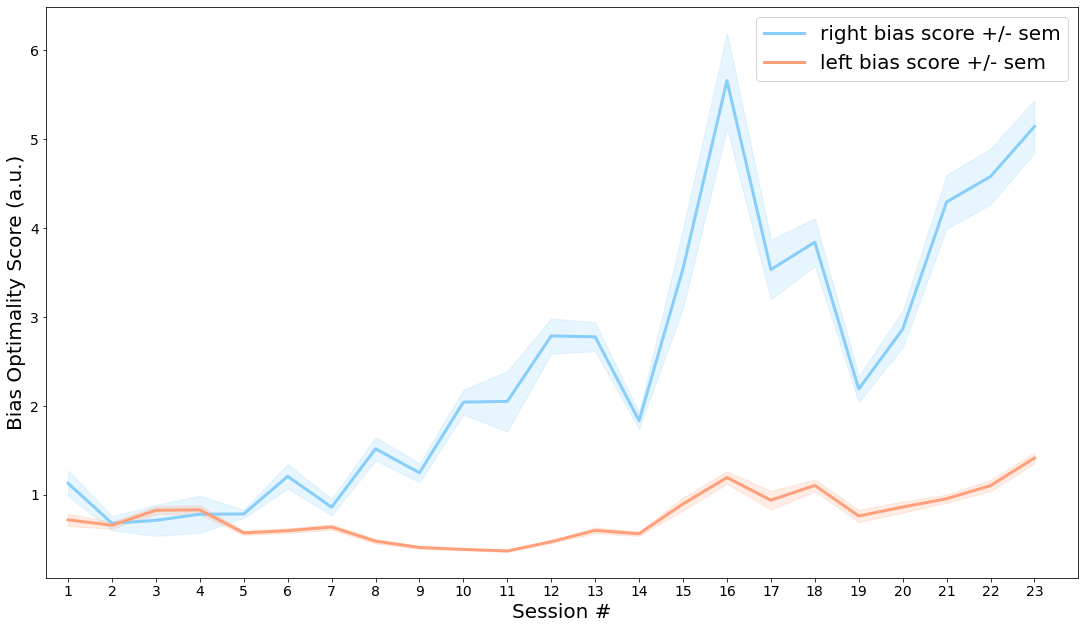

In [6]:
session_mean_system_of_eqs = np.load('session_mean_system_of_eqs_DAP009.npy')

session_mean_system_of_eqs = bias_optimality_test('DAP011')

fig4 = plt.figure()
axs4 = fig4.add_subplot(1, 1, 1)

axs4.plot(np.arange(1, len(session_mean_system_of_eqs[0, :])+1), session_mean_system_of_eqs[0, :], color='lightskyblue', lw=3, label='right bias score +/- sem')
# Plot 95% credible intervals on weights
axs4.fill_between(np.arange(1, len(session_mean_system_of_eqs[0, :])+1),
                 session_mean_system_of_eqs[0, :] - 1.96 * session_mean_system_of_eqs[1, :],
                 session_mean_system_of_eqs[0, :] + 1.96 * session_mean_system_of_eqs[1, :], color='lightskyblue', alpha=0.2)

axs4.plot(np.arange(1, len(session_mean_system_of_eqs[0, :])+1), session_mean_system_of_eqs[2, :], color='lightsalmon', lw=3, label='left bias score +/- sem')
# Plot 95% credible intervals on weights
axs4.fill_between(np.arange(1, len(session_mean_system_of_eqs[0, :])+1),
                 session_mean_system_of_eqs[2, :] - 1.96 * session_mean_system_of_eqs[3, :],
                 session_mean_system_of_eqs[2, :] + 1.96 * session_mean_system_of_eqs[3, :], color='lightsalmon', alpha=0.2)



axs4.set_xlim(left=0.5, right=len(session_mean_system_of_eqs[0, :])+1)
axs4.set_xlabel('Session #', size=20)
axs4.set_xticks(np.arange(1, len(session_mean_system_of_eqs[0, :])+1, 1))
axs4.set_ylabel('Bias Optimality Score (a.u.)', size=20)
#axs2.set_title('Reward Rate vs. Sessions', size=20)

axs4.legend(prop={'size': 20})

axs4.tick_params(axis='both', which='major', labelsize=14)

fig4.set_size_inches(18.5, 10.5)

In [ ]:
# now for all mice


all_mice = ['DAP007', 'DAP009', 'DAP011', 'DAP013', 'DAP014', 'DAP015', 'DAP017', 
           'DAP019', 'DAP022', 'DAP023', 'DAP024', 'DAP027', 'DAP028', 'DAP031', 'DAP033', 'DAP035', 'DAP037']

#all_mice = ['DAP007', 'DAP009', 'DAP011']

n_mice = len(all_mice)

mice_session_mean_br_eq = np.empty(n_mice, dtype=object)
mice_session_mean_bl_eq = np.empty(n_mice, dtype=object)

for mouse_index in range(n_mice):
    
    session_mean_system_of_eqs = bias_optimality_test(all_mice[mouse_index])
    
    mice_session_mean_br_eq[mouse_index] = session_mean_system_of_eqs[0, :]
    
    print(len(session_mean_system_of_eqs[0, :]))
    mice_session_mean_bl_eq[mouse_index] = session_mean_system_of_eqs[2, :]
    

max_session_array = np.array([len(el) for el in mice_session_mean_br_eq])

# find the smallest number of trials that a mouse has, this will be no. of windows
n_sessions_min = int(np.min(max_session_array))


mice_normalised_session_br_optim_test = np.empty((n_mice, n_sessions_min))
mice_normalised_session_bl_optim_test = np.empty((n_mice, n_sessions_min))



for i in range(n_mice):
    

    if max_session_array[i] != n_sessions_min:

        window_length = int(np.floor(max_session_array[i]/n_sessions_min))
        remainder = int(max_session_array[i] % n_sessions_min)
#         print('n_trials', max_session_array[i])
#         print('window_length', window_length)
#         print('remainder', remainder)
        
        if remainder != 0:
        
            mice_normalised_session_br_optim_test[i, :] = np.mean(mice_session_mean_br_eq[i][:-remainder].reshape(-1, window_length), 1)
            mice_normalised_session_br_optim_test[i, -1] = np.mean(mice_session_mean_br_eq[i][-(remainder+window_length):])
            
            mice_normalised_session_bl_optim_test[i, :] = np.mean(mice_session_mean_bl_eq[i][:-remainder].reshape(-1, window_length), 1)
            mice_normalised_session_bl_optim_test[i, -1] = np.mean(mice_session_mean_bl_eq[i][-(remainder+window_length):])
            
            
        if remainder == 0:
            
            mice_normalised_session_br_optim_test[i, :] = np.mean(mice_session_mean_br_eq[i].reshape(-1, window_length), 1)
            mice_normalised_session_bl_optim_test[i, :] = np.mean(mice_session_mean_bl_eq[i].reshape(-1, window_length), 1)
            

    else:
        mice_normalised_session_br_optim_test[i, :] = mice_session_mean_br_eq[i]
        mice_normalised_session_bl_optim_test[i, :] = mice_session_mean_bl_eq[i]
     



    #axs3.plot(np.arange(1, n_sessions_min+1), mice_normalised_session_RR[i, :], lw=0.8, color='k')
 

sem_normalised_session_br_optim_test = np.std(mice_normalised_session_br_optim_test, axis=0)/np.sqrt(n_mice)
sem_normalised_session_bl_optim_test = np.std(mice_normalised_session_bl_optim_test, axis=0)/np.sqrt(n_mice)


all_mice_normalised_session_bias_optimality = np.array([np.mean(mice_normalised_session_br_optim_test, axis=0), sem_normalised_session_br_optim_test, np.mean(mice_normalised_session_bl_optim_test, axis=0), sem_normalised_session_bl_optim_test])

np.save('all_mice_normalised_session_bias_optimality', all_mice_normalised_session_bias_optimality)





In [ ]:
all_mice_normalised_session_bias_optimality = np.load('all_mice_normalised_session_bias_optimality.npy')

fig5 = plt.figure()
axs5 = fig5.add_subplot(1, 1, 1)


plt.plot(np.arange(1, n_sessions_min+1), all_mice_normalised_session_bias_optimality[0, :], color='lightskyblue', lw=2, label='right bias score +/- sem')
# Plot 95% credible intervals on weights
plt.fill_between(np.arange(1, n_sessions_min+1),
                 all_mice_normalised_session_bias_optimality[0,:] - 1.96 * all_mice_normalised_session_bias_optimality[1,:],
                 all_mice_normalised_session_bias_optimality[0,:] + 1.96 * all_mice_normalised_session_bias_optimality[1,:], color='lightskyblue', alpha=0.2)

plt.plot(np.arange(1, n_sessions_min+1), all_mice_normalised_session_bias_optimality[2,:], color='lightsalmon', lw=2, label='left bias score +/- sem')
# Plot 95% credible intervals on weights
plt.fill_between(np.arange(1, n_sessions_min+1),
                 all_mice_normalised_session_bias_optimality[2,:] - 1.96 * all_mice_normalised_session_bias_optimality[3,:],
                 all_mice_normalised_session_bias_optimality[2,:] + 1.96 * all_mice_normalised_session_bias_optimality[3,:], color='lightsalmon', alpha=0.2)

axs5.set_xlim(left=0.5, right=len(session_mean_system_of_eqs[0, :]))
axs5.set_ylim(bottom=0.0, top=3.5)
axs5.set_xlabel('Normalised Sessions', size=20, labelpad=15)
axs5.set_xticks(np.arange(1, len(session_mean_system_of_eqs[0, :]), 1))
axs5.set_ylabel('Bias Optimality Score (a.u.)', size=20)
#axs2.set_title('Reward Rate vs. Sessions', size=20)

axs5.legend(prop={'size': 20})

axs5.tick_params(axis='both', which='major', labelsize=14, labelbottom=False, bottom=False)

fig5.set_size_inches(18.5, 10.5)


In [ ]:
import numpy_indexed as npi

a = [-0.5, -0.25, 0, 0.25, 0.5]
b = [0, 1]
c = [1,2,3]

A = np.random.choice(a, 10)
B = np.random.choice(b, 10)
C = np.random.choice(c, 10)

print('A', A)
print('B', B)
print('C', C)


unique_vals, mean = npi.group_by((A, B)).mean(C)

print('unique_vals', unique_vals)
print('mean', mean)

point_5_indexes = npi.group_by((A, B)).mean(C)[0][0] == 0.5
left_indexes = npi.group_by((A, B)).mean(C)[0][1] == 0

print(point_5_indexes & left_indexes)


In [ ]:
all_mice = ['DAP007', 'DAP009', 'DAP011', 'DAP013', 'DAP014', 'DAP015', 'DAP017', 
           'DAP019', 'DAP022', 'DAP023', 'DAP024', 'DAP027', 'DAP028', 'DAP031', 'DAP033', 'DAP035', 'DAP037']

times = []

for mouse_name in all_mice:
    mouse_fit = loadMouseWeights(mouse_name, iteration=0)
    times.append(mouse_fit['duration'].seconds)



In [ ]:
print(np.mean(times)/60)